## Table Of Content
* [Import Library](#import)
* [Data Preprocessing](#data-preprocessing)
    * [Ganti Nama File](#ganti-nama)
    * [Folder Dataset](#folder-dataset)
    * [Visualisasi Data](#visualisasi-data)
    * [Load Data](#load-data)
    * [Data Augmentasi](#data-augmentasi)
    * [Visualisasi Data Augmentasi](#data-augmentasi2)
* [Modelling](#modelling)
    * [Membuat Model](#createmodel)
    * [Compile Model](#compile)
    * [Fitting Model](#fit)
    * [History Fit Model](#history)
    * [Grafik Akurasi dan Loss](#grafik)
* [Evaluasi](#evaluasi)
    * [Confusion Matrix](#confmatrix)
    * [Score Model](#score)
* [Save Model](#save)

## Import Library <a class="anchor" id="import"></a>

In [2]:
#General Use
import numpy as np
import pandas as pd
import os
import warnings
import glob

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import confusion_matrix
import plotly.io as pio

#Data Preparation
import tensorflow as tf
from tensorflow import image
from keras.preprocessing.image import ImageDataGenerator
import cv2 as cv

#Model
from keras import Sequential

In [3]:
warnings.filterwarnings('ignore')

## Data Preprocessing <a class="anchor" id="data-preprocessing"></a>

### Ganti Nama File <a class="anchor" id="ganti-nama"></a>

In [ ]:
# path = os.chdir("Car-Bike-Dataset/Car/")

# i = 0
# for file in os.listdir(path):
#     new_file_name = "Car{}.jpg".format(i)
#     os.rename(file, new_file_name)

#     i += 1

### Folder Dataset <a class="anchor" id="folder-dataset"></a>

In [4]:
# Folder Dataset
file_path = 'Car-Bike-Dataset/'

# Nama Class
classes = sorted(os.listdir(file_path))
print(f'Class : {classes}')

# Distribusi Class
class_dis = [len(os.listdir(file_path + name)) for name in classes]

Class : ['Bike', 'Car']


### Visualisasi Distribusi Data <a class="anchor" id="visualisasi-data"></a>

In [5]:
%pip install kaleido

Note: you may need to restart the kernel to use updated packages.


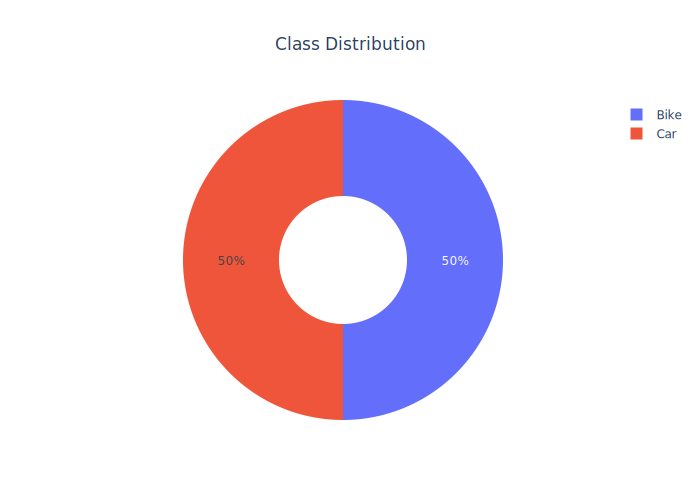

In [6]:
fig = px.pie(names=classes, values=class_dis, title="Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.5}})
fig.show(renderer="svg")

### Load Data <a class="anchor" id="load-data"></a>

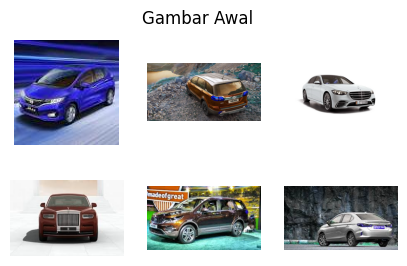

In [5]:
car = 'Car-Bike-Dataset/Car/*.jpg'

images = [cv.imread(image) for image in glob.glob(car)]
rows = 2
cols = 3
fig = plt.figure(figsize=(5, 3))
for i in range(0, rows * cols):
    fig.add_subplot(rows, cols, i+1)
    plt.axis('off')
    plt.imshow(images[i])
    plt.suptitle('Gambar Awal')

### Data Augmentasi <a class="anchor" id="data-augmentasi"></a>

In [6]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
BATCH_SIZE = 64

img_generator = ImageDataGenerator(
    rescale = 1/255.,           # Normalisasi 1/255
    horizontal_flip = True,     # Flip Horizontal
    validation_split = 0.2
)

#Membagi ke training set dan test set
train_set = img_generator.flow_from_directory(
    file_path,
    color_mode= 'rgb',
    class_mode = 'binary',
    target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    shuffle = True,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = 'training'
)

test_set = img_generator.flow_from_directory(
    file_path,
    color_mode= 'rgb',
    class_mode = 'binary',
    target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    shuffle = False,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = 'validation'
)


Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [7]:
for i, d in train_set:
    print(i.shape)
    print(d.shape)
    break

(64, 128, 128, 3)
(64,)


### Visualisasi Data Augmentasi <a class="anchor" id="data-augmentasi2"></a>
- Normalisasi
- Horizontal Flip
- Resize (128 x 128)

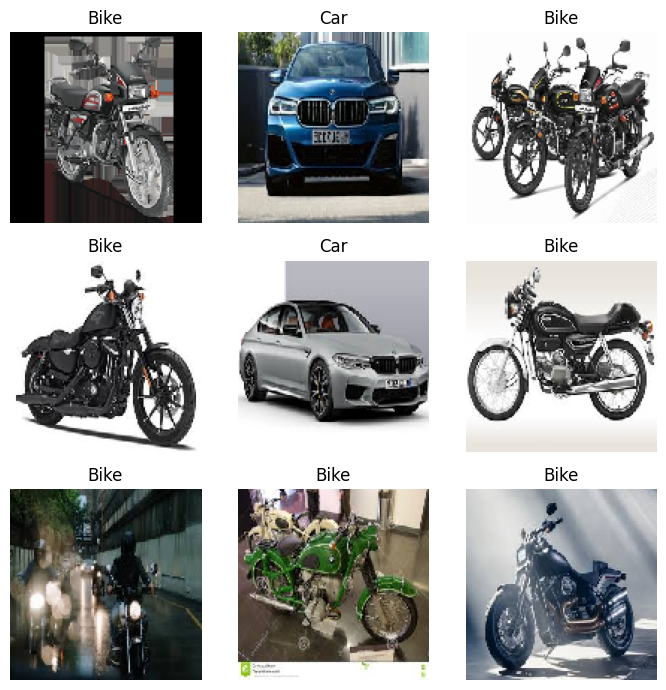

In [8]:
n_images = 10
plt.figure(figsize=(7, 7))
# DictionaryIterator
images, labels = train_set.next()
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(classes[labels[i].astype("uint8")])
    plt.axis("off")
plt.tight_layout()
plt.show()

## Modelling <a class="anchor" id="modelling"></a>

### Membuat Model <a class="anchor" id="createmodel"></a>

In [9]:
model = Sequential([
  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation = 'sigmoid' ) # Output layer
])

model.build(input_shape = (None,128,128,3)) # Dimensi 128 x 128, 3 Color Channel
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 256)     7168      
                                                                 
 average_pooling2d (AverageP  (None, 63, 63, 256)      0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 63, 63, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       295040    
                                                                 
 average_pooling2d_1 (Averag  (None, 30, 30, 128)      0         
 ePooling2D)                                                     
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 128)       0

### Compile Model <a class="anchor" id="compile"></a>

In [10]:
model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'])

### Fitting Model <a class="anchor" id="fit"></a>

In [11]:
n_epochs = 10

history = model.fit(
  train_set,
  validation_data = test_set,
  epochs = n_epochs
)

Epoch 1/10
50/50 [==============================] - 397s 8s/step - loss: 0.6528 - accuracy: 0.6172 - val_loss: 0.5396 - val_accuracy: 0.7387
Epoch 2/10
50/50 [==============================] - 422s 8s/step - loss: 0.4495 - accuracy: 0.8012 - val_loss: 0.4273 - val_accuracy: 0.8075
Epoch 3/10
50/50 [==============================] - 373s 8s/step - loss: 0.2530 - accuracy: 0.8941 - val_loss: 0.3458 - val_accuracy: 0.8712
Epoch 4/10
50/50 [==============================] - 383s 8s/step - loss: 0.2153 - accuracy: 0.9081 - val_loss: 0.3015 - val_accuracy: 0.8650
Epoch 5/10
50/50 [==============================] - 353s 7s/step - loss: 0.1830 - accuracy: 0.9262 - val_loss: 0.2116 - val_accuracy: 0.9237
Epoch 6/10
50/50 [==============================] - 349s 7s/step - loss: 0.1692 - accuracy: 0.9353 - val_loss: 0.2069 - val_accuracy: 0.9275
Epoch 7/10
50/50 [==============================] - 343s 7s/step - loss: 0.1394 - accuracy: 0.9416 - val_loss: 0.1880 - val_accuracy: 0.9300
Epoch 8/10
50

### History Fit Model <a class="anchor" id="history"></a>

In [12]:
data = pd.DataFrame(history.history)
data.head(n_epochs)

,loss,accuracy,val_loss,val_accuracy
0,0.652844,0.617188,0.539581,0.73875
1,0.449527,0.801250,0.427308,0.80750
2,0.253034,0.894063,0.345804,0.87125
3,0.215296,0.908125,0.301537,0.86500
4,0.182986,0.926250,0.211574,0.92375
5,0.169207,0.935313,0.206934,0.92750
6,0.139446,0.941562,0.187962,0.93000
7,0.135410,0.946563,0.205717,0.91500
8,0.098251,0.960625,0.182605,0.93500
9,0.098400,0.960312,0.207209,0.93125


### Grafik Akurasi dan Loss <a class="anchor" id="grafik"></a>

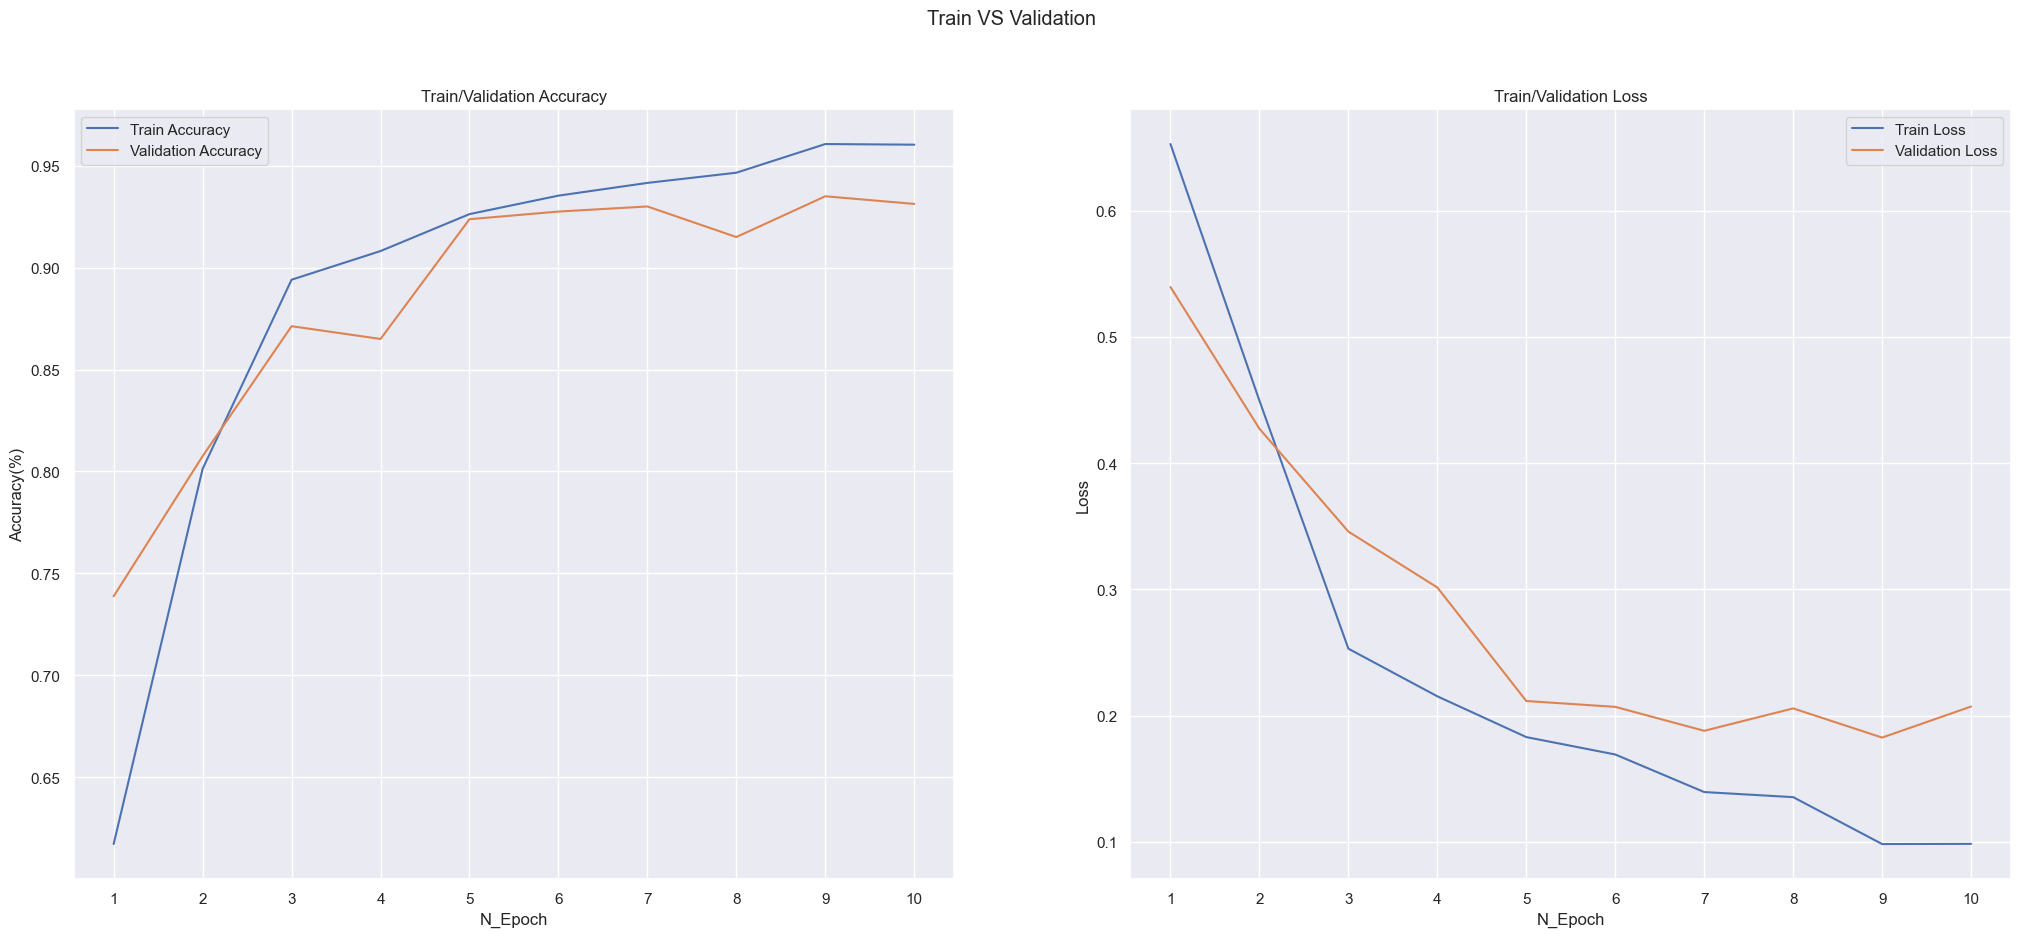

In [13]:
epoch = [i+1 for i in range(n_epochs)]

sns.set_theme()

plt.figure(figsize=(25, 10))
plt.suptitle('Train VS Validation')

#Subplot Akurasi
plt.subplot(1,2,1)
sns.lineplot(x=epoch,y = history.history['accuracy'],label ='Train Accuracy')
sns.lineplot(x=epoch,y = history.history['val_accuracy'],label ='Validation Accuracy')

plt.xticks(epoch)
plt.ylabel('Accuracy(%)')
plt.xlabel('N_Epoch')
plt.title("Train/Validation Accuracy")

#Subplot Loss
plt.subplot(1,2,2)
sns.lineplot(x=epoch,y = history.history['loss'],label ='Train Loss')
sns.lineplot(x=epoch,y = history.history['val_loss'],label ='Validation Loss')

plt.xticks(epoch)
plt.title("Train/Validation Loss")
plt.xlabel('N_Epoch')
plt.ylabel('Loss')
plt.show()

## Evaluasi <a class="anchor" id="evaluasi"></a>

In [14]:
#Membuat Prediksi
y_probs = model.predict(test_set)

y_predict = np.where(y_probs > 0.5, 1, 0)
p = test_set.classes
q = y_predict
p = np.array(p)
q = q.flatten()

13/13 [==============================] - 22s 2s/step


### Confusion Matrix <a class="anchor" id="confmatrix"></a>

[[382  18]
 [ 38 362]]


[Text(0, 0.5, 'Bike'), Text(0, 1.5, 'Car')]

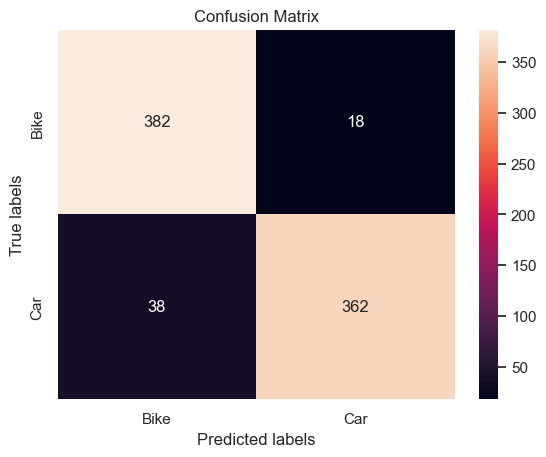

In [15]:
cfm = confusion_matrix(p, q)
print(cfm)
ax= plt.subplot()
sns.heatmap(cfm, annot=True, ax = ax, fmt='.0f')
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Bike', 'Car'])
ax.yaxis.set_ticklabels(['Bike', 'Car'])

### Score Model <a class="anchor" id="score"></a>

In [16]:
score = model.evaluate(test_set, verbose=1)
print(f'Test Loss    : {round(score[0] * 100,2)} %')
print(f'Test Akurasi : {round(score[1] * 100,2)} %')

13/13 [==============================] - 22s 2s/step - loss: 0.2067 - accuracy: 0.9287
Test Loss    : 20.67 %
Test Akurasi : 92.87 %


## Save Model <a class="anchor" id="save"></a>

In [17]:
from keras.models import model_from_json
# serialize model to json
json_model = model.to_json()
#save the model architecture to JSON file
with open('model/car_bike_model.json', 'w') as json_file:
    json_file.write(json_model)
#saving the weights of the model
model.save_weights('model/car_bike_weights.h5')